# 3 Drell-Yan Event Generator with VEGAS
Consider the Drell-Yan production process at an electron-positron collider, in which an electron and positron
collide to produce a virtual photon or a Z boson that then decays into a muon-antimuon pair,
$e^+e^- \rightarrow Z/\gamma \rightarrow \mu^+\mu^-$. As described in lecture and in Ref. [5], the differential cross section for center-of-mass energy $E_{CM} = \sqrt{\hat{s}}$ and scattering angle $\theta$ is given by

$$\frac{d\sigma}{d\Omega}(\hat{s}, \cos \theta) = \frac{\alpha^2}{4\hat{s}} \left[ A_0(\hat{s})(1 + \cos^2\theta) + A_1(\hat{s}) \cos \theta \right],$$

Where $A_0$ and $A_1$ are given by

$$
A_0(\hat{s}) = Q_e^2 - 2Q_eV_\mu V_e \chi_1(\hat{s}) + (A_\mu^2 + V_\mu^2)(A_e^2 + V_e^2) \chi_2(\hat{s}),
$$

$$
A_1(\hat{s}) = -4Q_eA_\mu A_e \chi_1(\hat{s}) + 8A_\mu V_\mu A_e V_e \chi_2(\hat{s}),
$$

and the $\chi_1$ and $\chi_2$ are given by

$$
\chi_1(\hat{s}) = \frac{\kappa\hat{s}(\hat{s} - M_Z^2)}{(\hat{s} - M_Z^2)^2 + \Gamma_Z^2 M_Z^2},
$$

$$
\chi_2(\hat{s}) = \frac{\kappa^2 \hat{s}^2}{(\hat{s} - M_Z^2)^2 + \Gamma_Z^2 M_Z^2},
$$

$$
\kappa = \frac{\sqrt{2}G_F M_Z^2}{4\pi\alpha}.
$$

Useful constants are given in the tables below.

| Fermions        | $Q_f$ | $V_f$                                | $A_f$ |
|-----------------|-------|--------------------------------------|-------|
| $u, c, t$       | $+\frac{2}{3}$ | $\left(+\frac{1}{2} - \frac{4}{3}\sin^2\theta_W\right)$ | $+\frac{1}{2}$ |
| $d, s, b$       | $-\frac{1}{3}$ | $\left(-\frac{1}{2} - \frac{2}{3}\sin^2\theta_W\right)$ | $-\frac{1}{2}$ |
| $\nu_e, \nu_\mu, \nu_\tau$ | $0$ | $\frac{1}{2}$ | $+\frac{1}{2}$ |
| $e, \mu, \tau$  | $-1$ | $\left(-\frac{1}{2} + 2\sin^2\theta_W\right)$ | $-\frac{1}{2}$ |

| Variable                | Symbol            | Value                                                   |
|-------------------------|-------------------|---------------------------------------------------------|
| conversion factor       | $GeV−2 ↔ pb$      | $3.894 \times 10^8 \, \text{pb} = 1 \, \text{GeV}^{-2}$ |
| Z boson mass            | $M_Z$             | $91.188 \, \text{GeV}$                                  |
| Z boson width           | $\Gamma_Z$        | $2.4414 \, \text{GeV}$                                  |
| QED running coupling    | $\alpha$          | $\frac{1}{132.507}$                                     |
| Fermi constant          | $G_F$             | $1.16639 \times 10^{-5} \, \text{GeV}^{-2}$             |
| Weinberg angle          | $\sin^2\theta_W$  | $0.222246$                                              |


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sp

Don't get scared with all these constants. I just copied the cosntants from the PDF table. We wont use most of them but maybe we will who knows! 

In [5]:
#Important constants
pb = 3.894e8 #pb equals GeV^-2
M_z = 91.188 #GeV
Gamma_z = 2.4414 #GeV
alpha = 1/132.507
G_f = 1.16639e-5 #GeV^-2 
sin2_theta = 0.222246 #sin^2(theta_w) 

#Fermions
#Charge of the fermions
Q_u, Q_c, Q_t = 2/3, 2/3, 2/3
Q_d, Q_s, Q_b = -1/3, -1/3, -1/3
Q_mue, Q_mumu, Q_mutau = 0, 0, 0
Q_e, Q_mu, Q_tau = -1, -1, -1

#vector coupling constants
V_u, V_c, V_t = 0.5 - (4/3)*sin2_theta, 0.5 - (4/3)*sin2_theta, 0.5 - (4/3)*sin2_theta
V_d, V_s, V_b = -0.5 - (2/3)*sin2_theta, -0.5 - (2/3)*sin2_theta, -0.5 - (2/3)*sin2_theta
V_mue, V_mumu, V_mutau = 0.5, 0.5, 0.5
V_e, V_mu, V_tau = -0.5 + (2)*sin2_theta, -0.5 + (2)*sin2_theta, -0.5 + (2)*sin2_theta

#axial coupling constants
A_u, A_c, A_t = 0.5, 0.5, 0.5
A_d, A_s, A_b = -0.5, -0.5, -0.5
A_mue, A_mumu, A_mutau = 0.5, 0.5, 0.5
A_e, A_mu, A_tau = -0.5, -0.5, -0.5

#kappa
kappa = (np.sqrt(2)*G_f*M_z**2)/(4*np.pi*alpha)

In [6]:
#We are logging the values of S and E
SMIN, SMAX =  10**2, 200**2

EMIN, EMAX = 10, 200
#cos(theta) so we just do theta here
THETAMIN, THETAMAX = np.pi, 2*np.pi

COSMIN, COSMAX = -1, 1

In [7]:
#functions to calculate the differential cross section

def s_to_E(s):
    return np.sqrt(s)

def chi_1(s):
    a = kappa * s * (s - M_z**2)
    b = (s - M_z**2)**2 + (M_z*Gamma_z)**2
    return a/b

def chi_2(s):
    a = (kappa * s)**2
    b = (s - M_z**2)**2 + (M_z*Gamma_z)**2
    return a/b

def A0(s):
    a = Q_e**2
    b = 2 * Q_e * V_mu * V_e * chi_1(s)
    c = (A_mu**2 + V_mu**2) * (A_e**2 + V_e**2) * chi_2(s)
    return a - b + c

def A1(s):
    a = 4 * Q_e * A_mu * A_e * chi_1(s)
    b = 8 * A_mu * V_mu * A_e * V_e * chi_2(s)
    return -a + b

#differential cross section
def f(s,theta):
    a = alpha**2/(4 * s)
    b = A0(s) * (1 + np.cos(theta)**2)
    c = A1(s) * np.cos(theta)
    return a * (b + c)


In [8]:
def lego_plot(xAmplitudes, yAmplitudes, nBins, xLabel, yLabel, title):
    x = np.array(xAmplitudes)  # turn x,y data into numpy arrays
    y = np.array(yAmplitudes)  # useful for regular matplotlib arrays

    fig = plt.figure()  # create a canvas, tell matplotlib it's 3d
    ax = fig.add_subplot(111, projection="3d")

    # make histograms - set bins
    hist, xedges, yedges = np.histogram2d(x, y, bins=(nBins, nBins))
    xpos, ypos = np.meshgrid(xedges[:-1] + xedges[1:], yedges[:-1] + yedges[1:])

    xpos = xpos.flatten() / 2.0
    ypos = ypos.flatten() / 2.0
    zpos = np.zeros_like(xpos)

    dx = xedges[1] - xedges[0]
    dy = yedges[1] - yedges[0]
    dz = hist.flatten()

    cmap = mpl.colormaps["jet"]
    max_height = np.max(dz)  # get range of colorbars so we can normalize
    min_height = np.min(dz)
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((k - min_height) / max_height) for k in dz]

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort="average")
    plt.title(title)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)   
    plt.show()

def plot_histograms(s_values, theta_values, nBins):
    # Plot histogram for S
    plt.figure(figsize=(10, 4))
    plt.hist(s_values, bins=nBins, color='skyblue', edgecolor='black')
    plt.title('Histogram of S Values')
    plt.xlabel('S')
    plt.ylabel('Frequency')
    plt.show()

    # Plot histogram for E
    plt.figure(figsize=(10, 4))
    plt.hist(s_to_E(s_values), bins=nBins, color='lightcoral', edgecolor='black')
    plt.title('Histogram of E Values')
    plt.xlabel('E')
    plt.ylabel('Frequency')
    plt.show()

    # Plot histogram for theta
    plt.figure(figsize=(10, 4))
    plt.hist(theta_values, bins=nBins, color='lightgreen', edgecolor='black')
    plt.title('Histogram of Theta Values')
    plt.xlabel('Theta')
    plt.ylabel('Frequency')
    plt.show()

    # Plot histogram for cos(theta)
    plt.figure(figsize=(10, 4))
    plt.hist(np.cos(theta_values), bins=nBins, color='salmon', edgecolor='black')
    plt.title('Histogram of Cos(Theta) Values')
    plt.xlabel('Cos(Theta)')
    plt.ylabel('Frequency')
    plt.show()

In [12]:
# sampled_values = []
# for _ in range(1_000_000):
#     random_s = np.random.uniform(SMIN, SMAX)
#     random_cos_theta = np.random.uniform(THETAMIN, THETAMAX)
#     value = f(random_s, random_cos_theta)
#     sampled_values.append(value)

# FMAX = max(sampled_values)
# print(FMAX)
FMAX = 6.78765661236851e-07

# Problem A: 

Use standard acceptance-rejection Monte Carlo to generate events (ECM, cos θ) for the DrellYan process in a range ECM ∈ [10, 200] GeV and cos θ ∈ [−1, 1]. Note, usually ECM is fixed in an electronpositron collider, but we will consider a range of energies, which is similar to the situation at a hadron
collider where the partonic center-of-mass energy is not known exactly.

In [8]:
def brute_force(nPoints, seed=None):
    nFunctionEval = 0
    s_rej_method = []
    theta_rej_method = []
    maxWeightEncounteredRej = -1.0e20
    generator = np.random.RandomState(seed=seed)
    while len(s_rej_method) < nPoints:
        rr = generator.uniform(size=3)
        s, theta = SMIN + rr[0] * (SMAX - SMIN), THETAMIN + rr[1] * (THETAMAX - THETAMIN)
        nFunctionEval += 1
        f_val = f(s, theta)
        if f_val > maxWeightEncounteredRej:
            maxWeightEncounteredRej = f_val
        if f_val > FMAX:
            print(
                f" f_val={f_val} exceeds FMAX={FMAX}, program will now exit"
            )
            exit(99)
        if f_val / FMAX > rr[2]:
            s_rej_method.append(s)
            theta_rej_method.append(theta)
    return {
        "S": s_rej_method,
        "theta": theta_rej_method,
        "nFunEval": nFunctionEval,
        "maxWeightEncountered": maxWeightEncounteredRej,
    }

In [11]:
bf = brute_force(100_000,64)

 f_val=6.788434534151476e-07 exceeds FMAX=6.78765661236851e-07, program will now exit
 f_val=6.788663449157157e-07 exceeds FMAX=6.78765661236851e-07, program will now exit
 f_val=6.788244902709578e-07 exceeds FMAX=6.78765661236851e-07, program will now exit
 f_val=6.788954740693256e-07 exceeds FMAX=6.78765661236851e-07, program will now exit
 f_val=6.789367818567315e-07 exceeds FMAX=6.78765661236851e-07, program will now exit


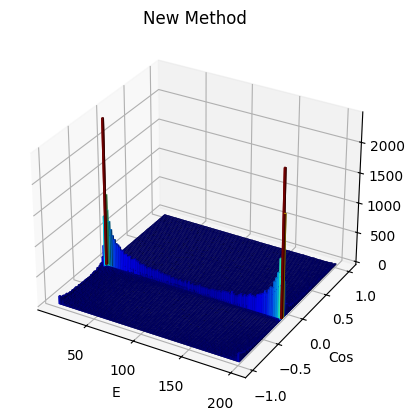

In [15]:
lego_plot(np.sqrt(bf["S"]), np.cos(bf["theta"]), 100, "E", "Cos", "New Method")

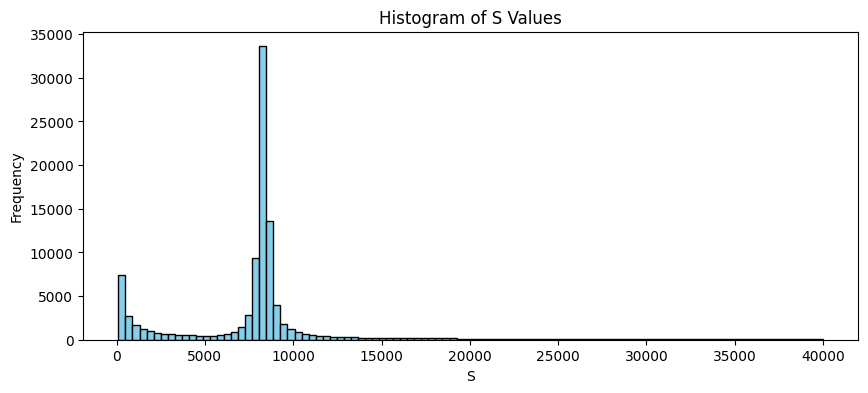

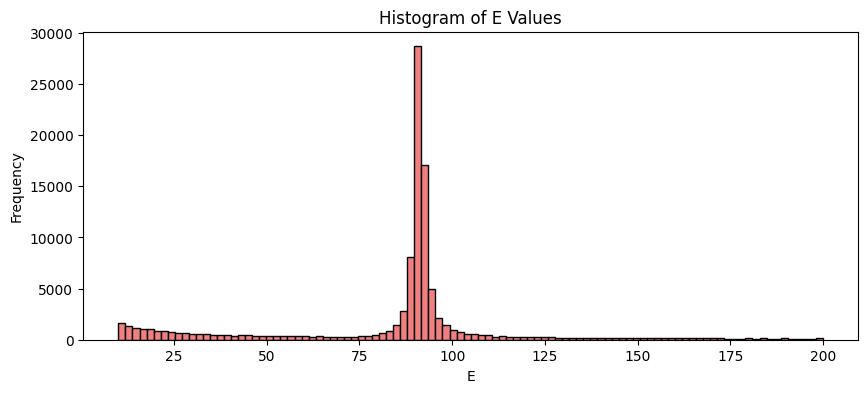

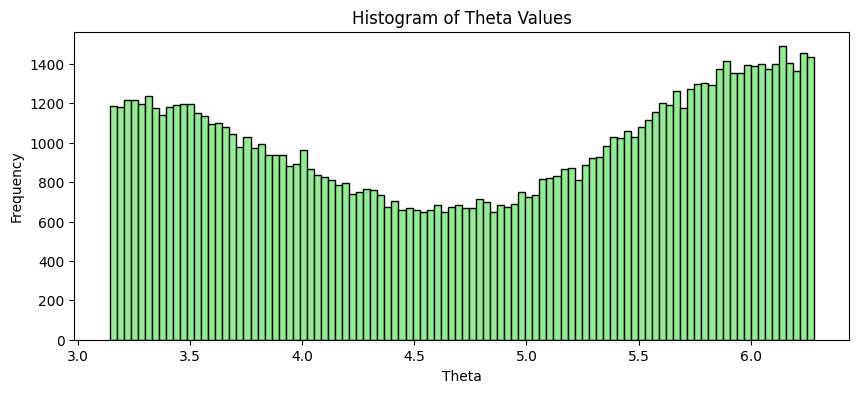

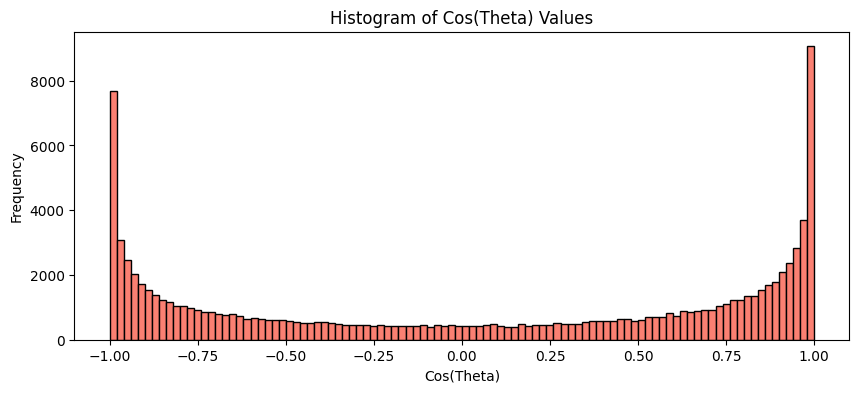

In [14]:
plot_histograms(bf["S"], bf["theta"], 100)


# Problem B : 
Use the VEGAS Monte Carlo method [6, 7] to generate events (ECM, cos θ) for the Drell-Yan
process in a range ECM ∈ [10, 200] GeV and cos θ ∈ [−1, 1]. Compare how many function evaluations are
needed to arrive at the same number of samples, e.g. 10,000. Discuss the settings you use for the VEGAS
algorithm, i.e. how many iterations, what kind of damping factor, and how many bins, etc.

In [21]:
sLow = SMIN + (SMAX - SMIN) / 10 * np.arange(10+1)
print(sLow)

[  100.  4090.  8080. 12070. 16060. 20050. 24040. 28030. 32020. 36010.
 40000.]


In [22]:
sLOW = np.linspace(SMIN, SMAX, 11)
print(sLOW)

[  100.  4090.  8080. 12070. 16060. 20050. 24040. 28030. 32020. 36010.
 40000.]


In [13]:
def setup_intervals(NN=100, KK=2000, nIterations=4000, alpha_damp=1.5, seed=None):
    """
    Input:
        NN: Number of intervals in [XMIN, XMAX] or [YMIN, YMAX]
        KK: function evaluations per iteration
        nIterations: number of iterations
        alpha_damp: damping parameter in the Vegas algorithm
    Return:
        Intervals specified by xLow, yLow: each is a 1D numpy array of size NN+1, with
        xLow[0] = 0, xLow[NN] = ym; yLow[0] = 0, yLow[NN] = ym
    """

    # intitial intervals: uniform intervals between XMIN/YMIN and XMAX/YMAX
    #sLow = SMIN + (SMAX - SMIN) / NN * np.arange(NN + 1)
    sLow = np.linspace(SMIN, SMAX, NN + 1)
    del_x = np.ones(NN) * (SMAX - SMIN) / NN
    p_s = np.ones(NN) / (SMAX - SMIN)  # probability density in each interval

    #thetaLow = THETAMIN + THETAMAX / NN * np.arange(NN + 1)
    thetaLow = np.linspace(THETAMIN, THETAMAX, NN + 1)
    del_theta = np.ones(NN) * (THETAMAX - THETAMIN) / NN
    p_theta = np.ones(NN) / (THETAMAX - THETAMIN)

    generator = np.random.RandomState(seed=seed)
    for _ in range(nIterations):
        ixLow = generator.randint(0, NN, size=KK)
        xx = sLow[ixLow] + del_x[ixLow] * generator.uniform(size=KK)
        iyLow = generator.randint(0, NN, size=KK)
        yy = thetaLow[iyLow] + del_theta[iyLow] * generator.uniform(size=KK)
        ff = f(xx, yy)
        f2barx = np.array(
            [sum((ff[ixLow == i] / p_theta[iyLow[ixLow == i]]) ** 2) for i in range(NN)]
        )
        fbarx = np.sqrt(f2barx)
        f2bary = np.array(
            [sum((ff[iyLow == i] / p_s[ixLow[iyLow == i]]) ** 2) for i in range(NN)]
        )
        fbary = np.sqrt(f2bary)
        fbardelxSum = np.sum(fbarx * del_x)
        fbardelySum = np.sum(fbary * del_theta)
        logArgx = fbarx * del_x / fbardelxSum
        logArgy = fbary * del_theta / fbardelySum
        mmx = KK * pow((logArgx - 1) / np.log(logArgx), alpha_damp)
        mmx = mmx.astype(int)
        mmx = np.where(mmx > 1, mmx, 1)
        mmy = KK * pow((logArgy - 1) / np.log(logArgy), alpha_damp)
        mmy = mmy.astype(int)
        mmy = np.where(mmy > 1, mmy, 1)
        xLowNew = [sLow[i] + np.arange(mmx[i]) * del_x[i] / mmx[i] for i in range(NN)]
        xLowNew = np.concatenate(xLowNew, axis=0)
        yLowNew = [thetaLow[i] + np.arange(mmy[i]) * del_theta[i] / mmy[i] for i in range(NN)]
        yLowNew = np.concatenate(yLowNew, axis=0)
        nCombx = int(len(xLowNew) / NN)
        nComby = int(len(yLowNew) / NN)
        i = np.arange(NN)
        sLow[:-1] = xLowNew[i * nCombx]
        thetaLow[:-1] = yLowNew[i * nComby]
        del_x = np.diff(sLow)
        del_theta = np.diff(thetaLow)
        p_theta = 1.0 / del_x / NN
        p_s = 1.0 / del_theta / NN

    return sLow, thetaLow, del_x, del_theta


In [14]:


def vegas(
    nPoints,
    vegasRatioFactor,
    NN=100,
    KK=2000,
    nIterations=4000,
    alpha_damp=1.5,
    seed=None,
):
    xLow, yLow, delx, dely = setup_intervals(NN, KK, nIterations, alpha_damp, seed)
    vegasRatioMax = vegasRatioFactor * FMAX * NN * NN * delx[NN - 2] * dely[NN - 2]
    nFunctionEval = 0
    yy1_vegas_method = []
    yy2_vegas_method = []
    yy1_vrho_method = []
    yy2_vrho_method = []
    maxWeightEncountered = -1.0e20

    generator = np.random.RandomState(seed=seed)
    while len(yy1_vegas_method) < nPoints:
        ixLow = generator.randint(0, NN)
        xx = xLow[ixLow] + delx[ixLow] * generator.uniform()
        iyLow = generator.randint(0, NN)
        yy = yLow[iyLow] + delx[iyLow] * generator.uniform()
        yy1_vrho_method.append(xx)
        yy2_vrho_method.append(yy)
        nFunctionEval += 1
        f_val = f(xx, yy)
        ratio = f_val * NN * NN * delx[ixLow] * dely[iyLow]
        if ratio > maxWeightEncountered:
            maxWeightEncountered = ratio
        if ratio > vegasRatioMax:
            print(
                f"ratio={ratio} exceeds vegasRatioMax={vegasRatioMax}, yy={yy} program will now exit "
            )
            exit(99)
        if ratio / vegasRatioMax > generator.uniform():
            yy1_vegas_method.append(xx)
            yy2_vegas_method.append(yy)

    return {
        "yy1vrho": yy1_vrho_method,
        "yy2vrho": yy2_vrho_method,
        "yy1vegas": yy1_vegas_method,
        "yy2vegas": yy2_vegas_method,
        "nFunEval": nFunctionEval,
        "maxWeightEncountered": maxWeightEncountered,
        "vegasRatioMax": vegasRatioMax,
    }

In [15]:
vegas_result = vegas(1_000, 0.5, seed=64)

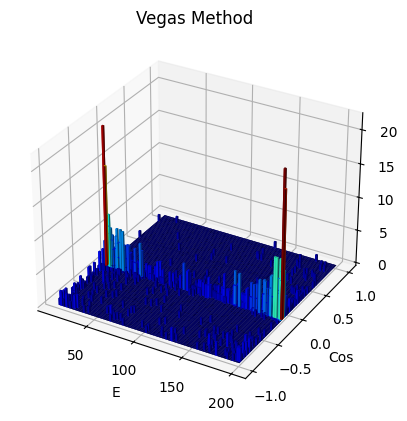

In [16]:
lego_plot(np.sqrt(vegas_result["yy1vegas"]), np.cos(vegas_result["yy2vegas"]), 100, "E", "Cos", "Vegas Method")